In [1]:
! pip install --quiet "seaborn" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "lightning>=2.0.0rc0" "ipython[notebook]>=8.0.0, <8.12.0" "pandas" "torchmetrics >=0.11.0" "torch>=1.8.1, <1.14.0" "torchmetrics>=0.7, <0.12"


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassF1Score
from torchvision import transforms
from prep import CustomImageDataset #класс с обработкой датасета - рентгеновские снимки
from prep_img import RandomTranslateCrop, CenterCrop #подгон под один размер

path_img = 'C:\\mimic-cxr-jpg\\train'
BATCH_SIZE = 32

In [3]:
train_label = "C:\\mimic-cxr-jpg\\train_set.csv"
val_label = "C:\\mimic-cxr-jpg\\val_set.csv"
test_label = "C:\\mimic-cxr-jpg\\test_set.csv"
train_set = CustomImageDataset(train_label,path_img,transform=CenterCrop(224))
val_set = CustomImageDataset(val_label,path_img,transform=CenterCrop(224)) #разбиваем данные на train val test
test_set = CustomImageDataset(test_label,path_img,transform=CenterCrop(224))

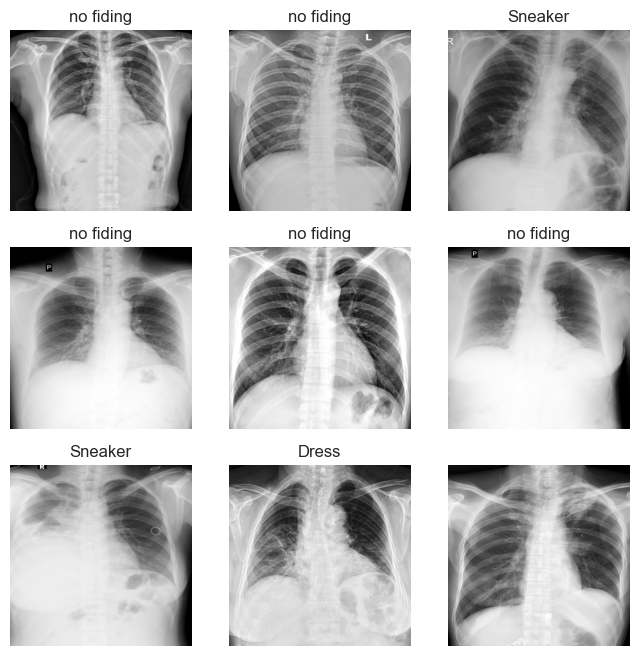

In [4]:
# import matplotlib.pyplot as plt
# labels_map = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot",
#     10: "",
#     11: "",
#     12: "",
#     13:"",
#     14:"no fiding"
# }
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(val_set), size=(1,)).item()
#     img, label = val_set[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [4]:
class LitMNIST(L.LightningModule):
    def __init__(self, hidden_size=64, learning_rate=2e-4, num_classes=15):
        super().__init__()

        # Set our init args as class attributes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        # Hardcode some dataset specific attributes
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)), #нормализация
            ]
        )
        self.dropout = nn.Dropout()
        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(50176, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1), #3 полносвязных слоя с дропаутом
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )
#метрики Accuracy - как раз точность, AUCROC и F1-score
        self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)

        self.train_auroc = MulticlassAUROC(num_classes=num_classes)
        self.val_auroc = MulticlassAUROC(num_classes=num_classes)
        self.test_auroc = MulticlassAUROC(num_classes=num_classes)

        self.train_f1 = MulticlassF1Score(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y) #функция потерь - кросс энтропия для задачи классификации

        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds,y) #обновляем метрики

        preds = torch.softmax(logits,dim=1)
        self.train_auroc.update(preds,y)

        preds = torch.argmax(logits, dim=1)
        self.train_f1.update(preds,y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        self.log("train_roc", self.train_auroc, prog_bar=True)
        self.log("train_f1", self.train_f1, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds,y)

        preds = torch.softmax(logits,dim=1)
        self.val_auroc.update(preds,y)

        preds = torch.argmax(logits, dim=1)
        self.val_f1.update(preds,y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_roc", self.val_auroc, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        preds = torch.softmax(logits,dim=1)
        self.test_auroc.update(preds, y)

        preds = torch.argmax(logits, dim=1)
        self.test_f1.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_roc", self.test_auroc, prog_bar=True)
        self.log("test_f1", self.test_f1, prog_bar=True)


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) #алгоритм спуска был заменен на оптимизатор Adam
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.set_train, self.set_val = train_set,val_set

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.set_test = test_set
# закидываем в данные в загрузчик и сверху делим в зависимости от стадии
    def train_dataloader(self):
        return DataLoader(self.set_train, batch_size=BATCH_SIZE, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.set_val, batch_size=BATCH_SIZE,num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.set_test, batch_size=BATCH_SIZE,num_workers=0)

In [5]:
model = LitMNIST()
trainer = L.Trainer(
    devices=1, accelerator="cpu",
    max_epochs=100, #обучение модели
    logger=CSVLogger(save_dir="logs/"),
)
#trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
#trainer.test()

,train_loss,val_loss,val_acc,val_roc,val_f1
epoch,,,,,
0,0.705125,NaN,NaN,NaN,NaN
0,0.714725,NaN,NaN,NaN,NaN
0,0.701524,NaN,NaN,NaN,NaN
0,0.717497,NaN,NaN,NaN,NaN
0,0.781384,NaN,NaN,NaN,NaN


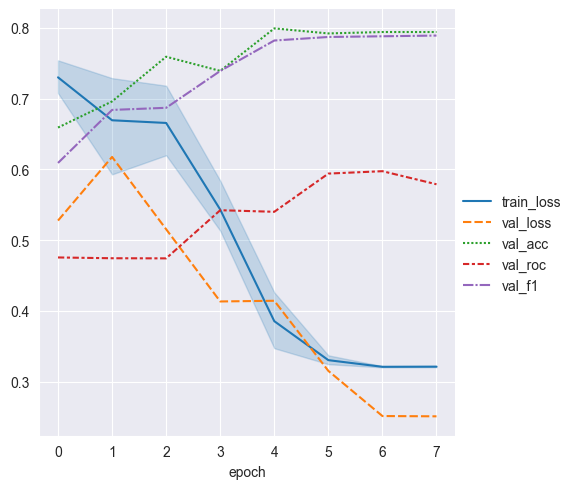

In [8]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics_fc.csv")
metrics = metrics.drop(["test_acc","test_roc","test_f1","test_loss"],axis=1)
del metrics["step"] #строим графики с csv файла
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [9]:
# model = LitMNIST.load_from_checkpoint("C:\\Users\\user\\PycharmProjects\\coursework\\logs\\lightning_logs\\version_0\\checkpoints\\epoch=357-step=123152.ckpt")
# trainer = L.Trainer(logger=CSVLogger(save_dir="logs/"))
# predictions = trainer.predict(model, dataloaders=DataLoader(val_set, batch_size=BATCH_SIZE,num_workers=0))
